In [1]:
""" Scratch file for testing code related to preprocessing and augmenting 3D images"""

' Scratch file for testing code related to preprocessing and augmenting 3D images'

# Load Data

In [2]:
import os
import cv2
import numpy as np;
import matplotlib.pyplot as plt
import torch 
import torchvision.transforms as transforms

In [16]:
# img_dir = "small_data_3d/original/train"
# mask_dir = "small_data_3d/ground_truth/train"
data_dir = "data/small_data_3d_5"
img_dir = os.path.join(data_dir, "original/valid")
mask_dir = os.path.join(data_dir, "ground_truth/valid")
img_files = os.listdir(img_dir)
mask_files = os.listdir(mask_dir)

(5, 512, 512) (5, 512, 512)


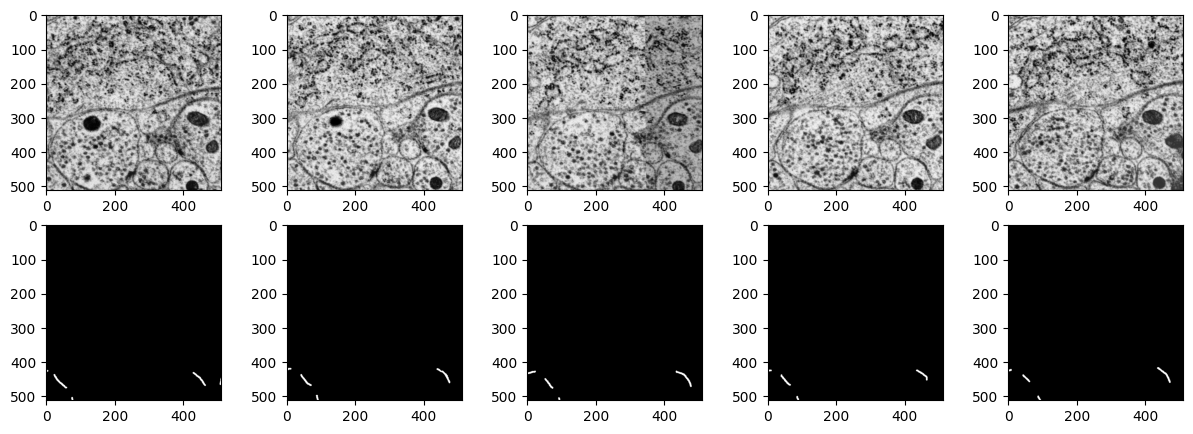

In [17]:
# sample image and mask
from visualize import *
k = 1
image = np.load(os.path.join(img_dir, img_files[k]))
mask = np.load(os.path.join(mask_dir, mask_files[k]))
depth, height, width = image.shape
print(image.shape, mask.shape)
fig, ax = plt.subplots(2, depth, figsize=(15, 5))
visualize_3d_slice(image, ax[0])
visualize_3d_slice(mask, ax[1])

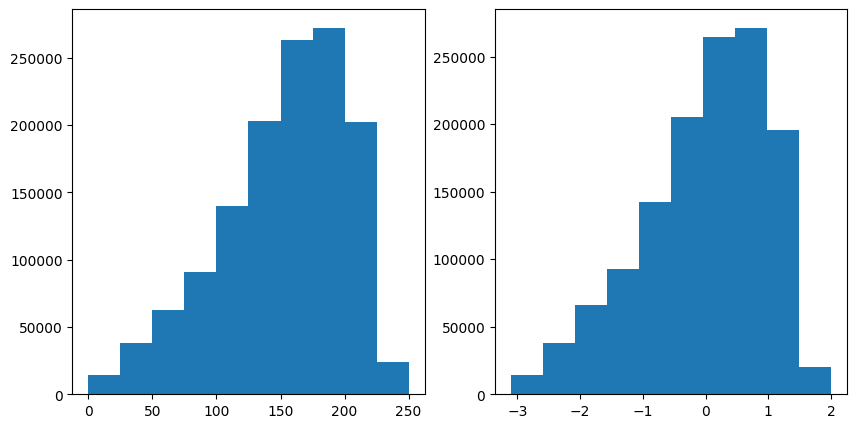

In [18]:
# normalize image
image_preprocessed = (image - image.mean()) / image.std()
image_tensor = torch.tensor(image_preprocessed).float()
image_tensor.dtype
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(image.flatten())
ax[1].hist(image_preprocessed.flatten())
plt.show()

In [19]:
mask_tensor = torch.tensor(mask).float()
print(mask_tensor.shape)
print(mask_tensor.dtype)

torch.Size([5, 512, 512])
torch.float32


In [22]:
one_hot_mask = torch.nn.functional.one_hot(mask_tensor.long(), num_classes=2)
print(one_hot_mask.shape)

torch.Size([5, 512, 512, 2])


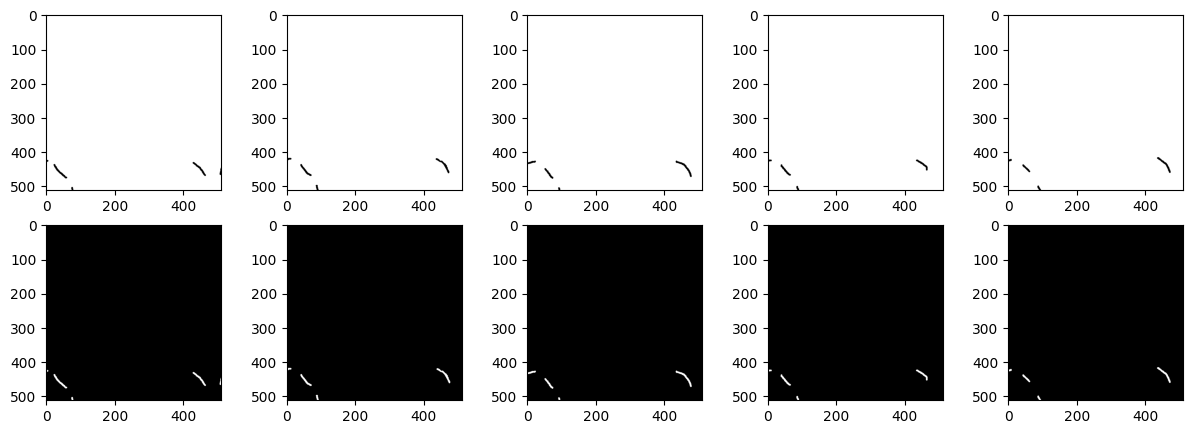

In [27]:
# 1 is white, 0 is black
fig, ax = plt.subplots(2, depth, figsize=(15, 5))
visualize_3d_slice(one_hot_mask[:, :, :, 0], ax[0])
visualize_3d_slice(one_hot_mask[:, :, :, 1], ax[1])

# Preprocess & Augment Data

In [28]:
import torchio as tio

/Users/huayinluo/Documents/code/gapjncsegmentation/gapvenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [55]:
augment = tio.Compose([
    # tio.RandomAnisotropy(p=0.25), # change spacing
    # tio.RandomAffine(), # rotation, scaling, shearing
    tio.RandomFlip(), # flip
    tio.RandomNoise(p=0.25), # add noise
    tio.RandomGamma(p=0.5), # change contrast
])

augm

In [56]:
tmp = augment(image_tensor.unsqueeze(0))
print(tmp.shape)

torch.Size([1, 5, 512, 512])


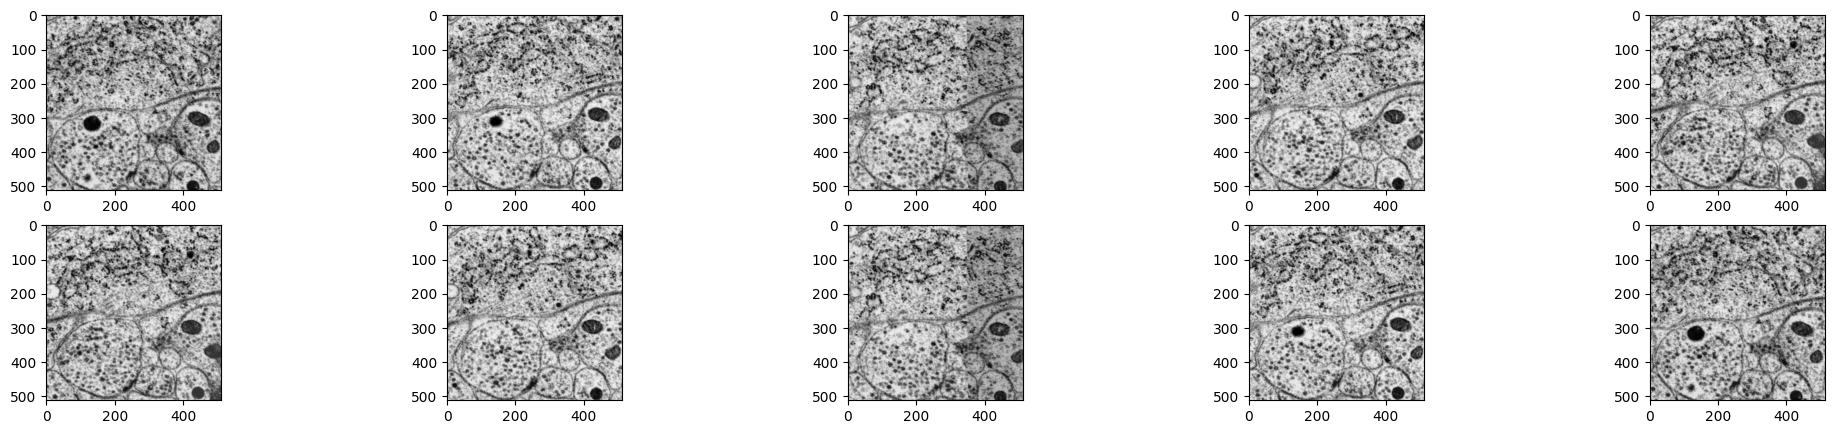

In [60]:
fig, ax = plt.subplots(2, 5, figsize=(25, 5))
visualize_3d_slice(image, ax[0])
visualize_3d_slice(tmp[0], ax[1])

# Test Model

In [37]:
from dataset import SliceDataset
import numpy as np
import os

data_dir = "data/small_data_256"
x_train_dir = os.path.join(data_dir, "original/train")
y_train_dir = os.path.join(data_dir, "ground_truth/train")
x_test_dir = os.path.join(data_dir, "original/test")
y_test_dir = os.path.join(data_dir, "ground_truth/test")

depth, height, width = np.load(os.path.join(x_train_dir, os.listdir(x_train_dir)[0])).shape
train_dataset = SliceDataset(x_train_dir, y_train_dir, image_dim = (width, height), augmentation=None)
valid_dataset = SliceDataset(x_test_dir, y_test_dir, image_dim = (width, height))

In [39]:
inputs, labels = valid_dataset[0]
inputs = inputs.unsqueeze(0).unsqueeze(0)
labels = labels.unsqueeze(0)
print(inputs.shape, labels.shape)

torch.Size([1, 1, 5, 256, 256]) torch.Size([1, 2, 5, 256, 256])


In [46]:
import models
import importlib
importlib.reload(models)
from models import *
from utilities import *
model = UNet()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
fp="/Users/huayinluo/Documents/code/gapjncsegmentation/models/tiny/tiny_epoch0.pk1"
model, optimizer, epoch, loss = load_checkpoint(model, optimizer, fp)

In [47]:
model = model.eval()

In [42]:
pred = model(inputs)
print(pred.shape)

torch.Size([1, 2, 5, 256, 256])


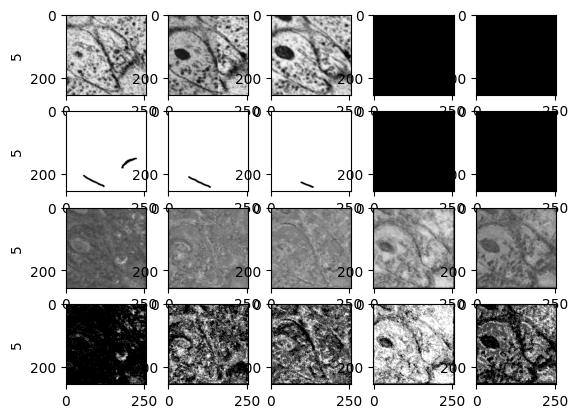

In [56]:
from visualize import *
input_img = inputs[0, 0].numpy()
label_img = labels[0, 0].numpy()
pred_img = pred[0, 1].detach().numpy()
pred_binary = torch.argmax(pred, dim=1).numpy()[0]
depth, height, width = input_img.shape
fig, ax = plt.subplots(4, depth)
visualize_3d_slice(input_img, ax[0], depth)
visualize_3d_slice(label_img, ax[1], depth)
visualize_3d_slice(pred_img, ax[2], depth)
visualize_3d_slice(pred_binary, ax[3], depth)

(array([211635.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 116045.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

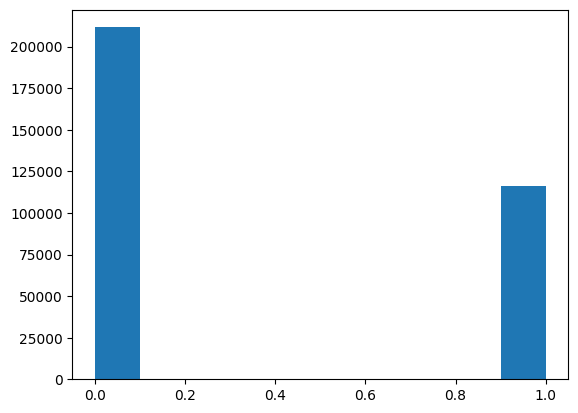

In [59]:
# pred_img has values from 0 to 1
# I need to convert it to binary mask
plt.hist(pred_binary.flatten())

In [43]:
import loss
importlib.reload(loss)
from loss import FocalLoss
w1, w2 = 0.2, 0.2
alpha = torch.Tensor([w1, w2/9])
gamma = 3
print(alpha)
criterion = FocalLoss(alpha=alpha)

tensor([0.2000, 0.0222])


In [44]:
criterion(pred, labels)

tensor(0.0392, grad_fn=<MeanBackward0>)